# Detecting malaria in blood smear images

### The Problem
Malaria is a mosquito-borne disease caused by the parasite _Plasmodium_. There are an estimated 219 million cases of malaria annually, with 435,000 deaths, many of whom are children. Malaria is prevalent in sub-tropical regions of Africa.

Microscopy is the most common and reliable method for diagnosing malaria and computing parasitic load. 

With this technique, malaria parasites are identified by examining a drop of the patient’s blood, spread out as a “blood smear” on a slide. Prior to examination, the specimen is stained (most often with the Giemsa stain) to give the parasites a distinctive appearance. This technique remains the gold standard for laboratory confirmation of malaria.

![Malaria-positive blood smear](https://www.cdc.gov/malaria/images/microscopy/parasites_arrows.jpg)

Blood smear from a patient with malaria; microscopic examination shows _Plasmodium falciparum_ parasites (arrows) infecting some of the patient’s red blood cells. (CDC photo)

However, the diagnostic accuracy of this technique is dependent on human expertise and can be affectived by and observer's variability.

### Deep learning as a diagnostic aid
Recent advances in computing and deep learning techniques have led to the applications of large-scale medical image analysis. Here, we aim to use a convolutional neural network (CNN) in order to quickly and accurately classify parasitized from healthy cells from blood smears.

This notebook is based on the work presented by [Dipanjan Sarkar](https://towardsdatascience.com/detecting-malaria-with-deep-learning-9e45c1e34b60)


### About the dataset
A [dataset](https://ceb.nlm.nih.gov/repositories/malaria-datasets/) of parasitized and unparasitized cells from blood smear slides was collected and annotated by [Rajaraman et al](https://doi.org/10.7717/peerj.4568). The dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells from Giemsa-stained thin blood smear slides from 150 P. falciparum-infected and 50 healthy patients collected and photographed at Chittagong Medical College Hospital, Bangladesh. There are also CSV files containing the Patient-ID to cell mappings for the parasitized and uninfected classes. The CSV file for the parasitized class contains 151 patient-ID entries. The slide images for the parasitized patient-ID “C47P8thinOriginal” are read from two different microscope models (Olympus and Motif). The CSV file for the uninfected class contains 201 entries since the normal cells from the infected patients’ slides also make it to the normal cell category (151+50 = 201).

The data appears along with the publication:
Rajaraman S, Antani SK, Poostchi M, Silamut K, Hossain MA, Maude, RJ, Jaeger S, Thoma GR. (2018) Pre-trained convolutional neural networks as feature extractors toward improved Malaria parasite detection in thin blood smear images. PeerJ6:e4568 https://doi.org/10.7717/peerj.4568

## Malaria Dataset
Medium post:
https://towardsdatascience.com/detecting-malaria-using-deep-learning-fd4fdcee1f5a

Data:
https://ceb.nlm.nih.gov/repositories/malaria-datasets/

## Data preprocessing

The [cell images](https://ceb.nlm.nih.gov/proj/malaria/cell_images.zip) dataset can be downloaded from the [NIH repository](https://ceb.nlm.nih.gov/repositories/malaria-datasets/).

Parasitized and healthy cells are sorted into their own folders.

In [1]:
import os

os.listdir('../data/cell_images/')

['Parasitized', 'Uninfected']

In [2]:
import random
import glob

# Get file paths for files
base_dir = os.path.join('../data/cell_images')
infected_dir = os.path.join(base_dir, 'Parasitized')
healthy_dir = os.path.join(base_dir, 'Uninfected')

# Glob is used to identify filepath patterns
infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(healthy_dir+'/*.png')

# View size of dataset
len(infected_files), len(healthy_files)

(13779, 13779)

Our data is evenly split between parasitized and healthy cells/images so we won't need to further balance our data.

## Split data into train, test, split sets

We can aggregate all of our images by adding the filepaths and labels into a single dataframe. 

We'll then shuffle and split the data into a 60/30/10 train/test/validation set.

In [3]:
import numpy as np
import pandas as pd

np.random.seed(1)

# Build a dataframe of filenames with labels
files = pd.DataFrame(data={'filename': infected_files, 'label': ['malaria' for i in range(len(infected_files))]})
files = pd.concat([files, pd.DataFrame(data={'filename': healthy_files, 'label': ['healthy' for i in range(len(healthy_files))]})])
files = files.sample(frac=1).reset_index(drop=True) # Shuffle rows
files.head()

,filename,label
0,../data/cell_images/Parasitized/C136P97ThinF_I...,malaria
1,../data/cell_images/Parasitized/C167P128ReThin...,malaria
2,../data/cell_images/Parasitized/C111P72ThinF_I...,malaria
3,../data/cell_images/Uninfected/C116P77ThinF_IM...,healthy
4,../data/cell_images/Parasitized/C60P21thinF_IM...,malaria


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(files.filename.values, files.label.values, test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

X_train.shape, X_val.shape, y_test.shape

((17361,), (1929,), (8268,))

As the dimensions of each image will vary, we will resize the images to be 125 x 125 pixels. The cv2 module can be used to load and resize images.

In [5]:
import cv2

# Read and resize images 
nrows = 125
ncols = 125
channels = 3

cv2.imread(X_train[0], cv2.IMREAD_COLOR)
cv2.resize(cv2.imread(X_train[0], cv2.IMREAD_COLOR), (nrows, ncols), interpolation=cv2.INTER_CUBIC).shape

(125, 125, 3)

In [6]:
import threading
from concurrent import futures

# Resize images
IMG_DIMS = (125, 125)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
X_train_inp = [(idx, img, len(X_train)) for idx, img in enumerate(X_train)]
X_val_inp = [(idx, img, len(X_val)) for idx, img in enumerate(X_val)]
X_test_inp = [(idx, img, len(X_test)) for idx, img in enumerate(X_test)]

print('Loading Train Images:')
X_train_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in X_train_inp],
                        [record[1] for record in X_train_inp],
                        [record[2] for record in X_train_inp])
X_train = np.array(list(X_train_map))

print('\nLoading Validation Images:')
X_val_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in X_val_inp],
                        [record[1] for record in X_val_inp],
                        [record[2] for record in X_val_inp])
X_val = np.array(list(X_val_map))

print('\nLoading Test Images:')
X_test_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in X_test_inp],
                        [record[1] for record in X_test_inp],
                        [record[2] for record in X_test_inp])
X_test = np.array(list(X_test_map))

X_train.shape, X_val.shape, X_test.shape

Loading Train Images:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_9: working on img num: 5000
ThreadPoolExecutor-0_6: working on img num: 10000
ThreadPoolExecutor-0_4: working on img num: 15000
ThreadPoolExecutor-0_1: working on img num: 17360

Loading Validation Images:
ThreadPoolExecutor-0_13: working on img num: 0
ThreadPoolExecutor-0_9: working on img num: 1928

Loading Test Images:
ThreadPoolExecutor-0_4: working on img num: 0
ThreadPoolExecutor-0_17: working on img num: 5000
ThreadPoolExecutor-0_6: working on img num: 8267


((17361, 125, 125, 3), (1929, 125, 125, 3), (8268, 125, 125, 3))

Using the matplotlib module, we can view a sample of the resized cell images. A brief inspection shows the presence of purple-stained parasites only in malaria-labeled samples.

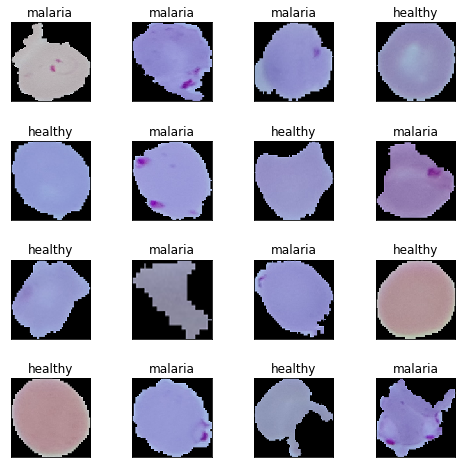

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , X_train.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(X_train[r[0]]/255.)
    plt.title('{}'.format(y_train[r[0]]))
    plt.xticks([]) , plt.yticks([])

## Model training
We can set some initial parameters for our model, including batch size, the number of classes, number of epochs, and image dimensions.

We'll encode the text category labels as 0 or 1.

In [8]:
from sklearn.preprocessing import LabelEncoder

BATCH_SIZE = 64
NUM_CLASSES = 2
EPOCHS = 25
INPUT_SHAPE = (125, 125, 3)

X_train_imgs_scaled = X_train / 255.
X_val_imgs_scaled = X_val / 255.

le = LabelEncoder()
le.fit(y_train)
y_train_enc = le.transform(y_train)
y_val_enc = le.transform(y_val)

print(y_train[:6], y_train_enc[:6])

['malaria' 'healthy' 'malaria' 'healthy' 'healthy' 'healthy'] [1 0 1 0 0 0]


### Simple CNN model

To start with, we'll build a simple CNN model with 2 convolution and pooling layers and a dense dropout layer for regularization.

In [9]:
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten

# Build a simple CNN
model = Sequential()
model.add(Conv2D(32, kernel_size=(5,5), strides=(1,1), activation='relu', input_shape=INPUT_SHAPE))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(1, activation='softmax'))

# out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

# model = tf.keras.Model(inputs=inp, outputs=out)

model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 121, 121, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        51264     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              50177000  
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1001      
Total para

We can evaluate the accuracy of model

In [10]:
import datetime
from keras import callbacks

# View accuracy
logdir = os.path.join('../tensorboard_logs', 
                      datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = callbacks.TensorBoard(logdir, histogram_freq=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=0.000001)
callbacks = [reduce_lr, tensorboard_callback]

history = model.fit(x=X_train_imgs_scaled, y=y_train_enc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(X_val_imgs_scaled, y_val_enc), 
                    callbacks=callbacks,
                    verbose=1)

Train on 17361 samples, validate on 1929 samples
Epoch 1/25
17361/17361 [==============================] - 1839s 106ms/step - loss: 8.0708 - acc: 0.4938 - val_loss: 7.3720 - val_acc: 0.5376
Epoch 2/25
 2624/17361 [===>..........................] - ETA: 1:09:17 - loss: 8.2932 - acc: 0.4798

KeyboardInterrupt: 